# Examining Pan-Cancer Differential Methylation Markers


## 1) Get your data
You may use any data set(s) you like, so long as they meet these criteria:

* Your data must be publically available for free.
* Your data should be interesting to _you_. You want your final project to be something you're proud of.
* Your data should be "big enough":
    - It should have at least 1,000 rows.
    - It should have enough of columns to be interesting.
    - If you have questions, contact a member of the instructional team.

## 2) Provide a link to your data
Your data is required to be free and open to anyone.
As such, you should have a URL which anyone can use to download your data:

* For my project I used TCGA methylation data downloaded from the [Genomic Data Commons](https://portal.gdc.cancer.gov).

## Problem statement.
Below, write a problem statement. Keep in mind that your task is to tease out relationships in your data and eventually build a predictive model. Your problem statement can be vague, but you should have a goal in mind. Your problem statement should be between one sentence and one paragraph.

* The goal of this project is to compare performance of supervised machine learning algorithms for predicting sample status (either tumor or normal) using potential pan-cancer methylation probes.

## 3) Import your data
In the space below, import your data.
If your data span multiple files, read them all in.
If applicable, merge or append them as needed.

In [132]:
#importing required packages and functions
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_squared_error

In [7]:
#reading in breast cancer data and removing rows with NAs.
BRCA = pd.read_csv('BRCA.csv', sep = ',', index_col = 0)
BRCA = BRCA.dropna(how = 'all')
BRCA_class = pd.read_csv('~/Documents/biof509/final-project/BRCA_class.csv', sep = ',', index_col = 0)['x']
BRCA_class.index = BRCA.columns

In [47]:
#separating tumors and normals
BRCA_normals = BRCA.loc[:,BRCA_class == 0]
BRCA_tumors = BRCA.loc[:,BRCA_class == 1]

In [109]:
#filtering out rows where absolute difference in methylation is < 0.3 between tumors and normals
BRCA = BRCA.loc[(abs(BRCA_normals.mean(axis = 1) - BRCA_tumors.mean(axis = 1)) > 0.35),:]

#replacing any remaining NAs with mean for that CpG site and sample type
BRCA.loc[:,BRCA_class == 1] = BRCA.loc[:,BRCA_class == 1].fillna(BRCA_tumors.mean())
BRCA.loc[:,BRCA_class == 0] = BRCA.loc[:,BRCA_class == 0].fillna(BRCA_normals.mean())

In [76]:
#reading in colon cancer data and removing rows with NAs.
COAD = pd.read_csv('~/Documents/biof509/final-project/COAD.csv', sep = ',', index_col = 0)
COAD = COAD.dropna(how = 'all')
COAD_class = pd.read_csv('~/Documents/biof509/final-project/COAD_class.csv', sep = ',', index_col = 0)['x']
COAD_class.index = COAD.columns

In [110]:
#separating tumors and normals
COAD_normals = COAD.loc[:,COAD_class == 0]
COAD_tumors = COAD.loc[:,COAD_class == 1]

#filtering out rows where absolute difference in methylation is < 0.3 between tumors and normals
COAD = COAD.loc[(abs(COAD_normals.mean(axis = 1) - COAD_tumors.mean(axis = 1)) > 0.35),:]

#replacing any remaining NAs with mean for that CpG site and sample type
COAD.loc[:,COAD_class == 1] = COAD.loc[:,COAD_class == 1].fillna(COAD_tumors.mean())
COAD.loc[:,COAD_class == 0] = COAD.loc[:,COAD_class == 0].fillna(COAD_normals.mean())

In [24]:
#reading in lung cancer data and removing rows with NAs.
LUAD = pd.read_csv('~/Documents/biof509/final-project/LUAD.csv', sep = ',', index_col = 0)
LUAD = LUAD.dropna(how = 'all')
LUAD_class = pd.read_csv('~/Documents/biof509/final-project/LUAD_class.csv', sep = ',', index_col = 0)['x']
LUAD_class.index = LUAD.columns

In [111]:
#separating tumors and normals
LUAD_normals = LUAD.loc[:,LUAD_class == 0]
LUAD_tumors = LUAD.loc[:,LUAD_class == 1]

#filtering out rows where absolute difference in methylation is < 0.3 between tumors and normals
LUAD = LUAD.loc[(abs(LUAD_normals.mean(axis = 1) - LUAD_tumors.mean(axis = 1)) > 0.35),:]

#replacing any remaining NAs with mean for that CpG site and sample type
LUAD.loc[:,LUAD_class == 1] = LUAD.loc[:,LUAD_class == 1].fillna(LUAD_tumors.mean())
LUAD.loc[:,LUAD_class == 0] = LUAD.loc[:,LUAD_class == 0].fillna(LUAD_normals.mean())

In [112]:
#merging breast, colon, and lung cancer data sets together
TCGA = BRCA.merge(COAD,left_index = True, right_index=True).merge(LUAD, left_index = True, right_index = True).transpose()
TCGA_class = BRCA_class.append(COAD_class).append(LUAD_class)

## 4) Show me the head of your data.

In [117]:
TCGA.head()

,cg00295794,cg00396667,cg00459623,cg00557947,cg00817367,cg01419831,cg01518607,cg01688536,cg01890568,cg01893212,...,cg25078444,cg25209842,cg26132774,cg26210445,cg26299169,cg26452868,cg26479667,cg26809635,cg27252696,cg27649239
TCGA-A2-A1FV-01A-11D-A13K-05,0.804098,0.804415,0.027807,0.868798,0.856811,0.821553,0.958562,0.871058,0.090245,0.923317,...,0.933043,0.795875,0.889620,0.917378,0.289994,0.943062,0.090924,0.811636,0.813934,0.850434
TCGA-A2-A1FW-01A-11D-A13K-05,0.903405,0.869170,0.717580,0.912815,0.935425,0.663264,0.948987,0.842029,0.397586,0.934050,...,0.939458,0.864307,0.915645,0.946833,0.511710,0.953965,0.038638,0.875273,0.786037,0.918238
TCGA-A2-A1FX-01A-11D-A13K-05,0.623872,0.718047,0.127058,0.333769,0.799612,0.427485,0.768805,0.207609,0.288757,0.758299,...,0.762585,0.624512,0.445409,0.755683,0.560186,0.829776,0.170291,0.689439,0.650224,0.745432
TCGA-A2-A1G0-01A-11D-A13K-05,0.566034,0.770583,0.018983,0.048856,0.041081,0.049035,0.732891,0.468389,0.273484,0.255730,...,0.423635,0.600893,0.497046,0.563073,0.153297,0.572538,0.258475,0.020553,0.358766,0.129208
TCGA-A2-A1G1-01A-21D-A13K-05,0.657521,0.538549,0.465221,0.625125,0.652166,0.583487,0.814104,0.446187,0.325014,0.508865,...,0.057779,0.048506,0.693632,0.617121,0.599538,0.795139,0.762259,0.660466,0.044718,0.637309


In [55]:
TCGA_class.head(20)

TCGA-A2-A1FV-01A-11D-A13K-05    1
TCGA-A2-A1FW-01A-11D-A13K-05    1
TCGA-A2-A1FX-01A-11D-A13K-05    1
TCGA-A2-A1G0-01A-11D-A13K-05    1
TCGA-A2-A1G1-01A-21D-A13K-05    1
TCGA-A2-A1G4-01A-11D-A13K-05    1
TCGA-A2-A1G6-01A-11D-A13K-05    1
TCGA-A7-A13G-01A-11D-A13K-05    1
TCGA-A7-A13G-01B-04D-A22R-05    1
TCGA-A7-A13G-11A-51D-A13T-05    0
TCGA-AO-A1KO-01A-31D-A13K-05    1
TCGA-AO-A1KP-01A-11D-A13K-05    1
TCGA-AO-A1KQ-01A-11D-A13K-05    1
TCGA-AO-A1KS-01A-11D-A13K-05    1
TCGA-AO-A1KT-01A-11D-A13K-05    1
TCGA-AQ-A1H2-01A-11D-A13K-05    1
TCGA-AQ-A1H3-01A-31D-A13K-05    1
TCGA-B6-A1KC-01A-11D-A13K-05    1
TCGA-B6-A1KC-01B-11D-A161-05    1
TCGA-B6-A1KF-01A-11D-A13K-05    1
Name: x, dtype: int64

## 5) Show me the shape of your data

In [114]:
TCGA.shape

(1752, 100)

## 6) Show me the proportion of missing observations for each column of your data

In [62]:
TCGA.isna().sum(axis = 1)/TCGA.shape[0]

TCGA-A2-A1FV-01A-11D-A13K-05    0.0
TCGA-A2-A1FW-01A-11D-A13K-05    0.0
TCGA-A2-A1FX-01A-11D-A13K-05    0.0
TCGA-A2-A1G0-01A-11D-A13K-05    0.0
TCGA-A2-A1G1-01A-21D-A13K-05    0.0
TCGA-A2-A1G4-01A-11D-A13K-05    0.0
TCGA-A2-A1G6-01A-11D-A13K-05    0.0
TCGA-A7-A13G-01A-11D-A13K-05    0.0
TCGA-A7-A13G-01B-04D-A22R-05    0.0
TCGA-A7-A13G-11A-51D-A13T-05    0.0
TCGA-AO-A1KO-01A-31D-A13K-05    0.0
TCGA-AO-A1KP-01A-11D-A13K-05    0.0
TCGA-AO-A1KQ-01A-11D-A13K-05    0.0
TCGA-AO-A1KS-01A-11D-A13K-05    0.0
TCGA-AO-A1KT-01A-11D-A13K-05    0.0
TCGA-AQ-A1H2-01A-11D-A13K-05    0.0
TCGA-AQ-A1H3-01A-31D-A13K-05    0.0
TCGA-B6-A1KC-01A-11D-A13K-05    0.0
TCGA-B6-A1KC-01B-11D-A161-05    0.0
TCGA-B6-A1KF-01A-11D-A13K-05    0.0
TCGA-B6-A1KN-01A-11D-A13K-05    0.0
TCGA-BH-A1EN-01A-11D-A13K-05    0.0
TCGA-BH-A1EN-11A-23D-A13T-05    0.0
TCGA-BH-A1EX-01A-11D-A13K-05    0.0
TCGA-BH-A1EY-01A-11D-A13K-05    0.0
TCGA-BH-A1EY-11B-21D-A13T-05    0.0
TCGA-BH-A1F2-01A-31D-A13K-05    0.0
TCGA-BH-A1F2-11A-32D-A13T-05

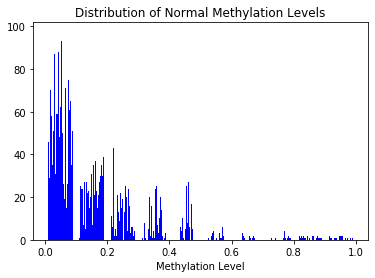

In [122]:
#plotting distribution of normal samples
plt.hist(TCGA.loc[TCGA_class == 0,:], range = (0,1), facecolor = 'blue');
plt.title('Distribution of Normal Methylation Levels');
plt.xlabel('Methylation Level');

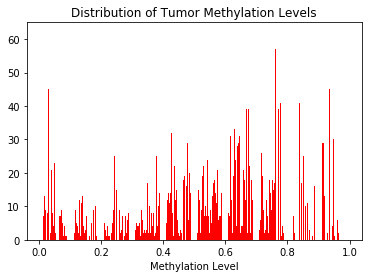

In [123]:
#plotting distribution of tumor samples
plt.hist(TCGA.loc[TCGA_class == 1,:], range = (0,1), facecolor = 'red');
plt.title('Distribution of Tumor Methylation Levels');
plt.xlabel('Methylation Level');
plt.ylim([0,65]);

## 8) What is your _y_-variable?
For final project, you will need to perform a statistical model. This means you will have to accurately predict some y-variable for some combination of x-variables. From your problem statement in part 7, what is that y-variable?

For my project, the y variable is the sample type, which is either tumor or normal (represented as 1 and 0, respectively).

## KNN and Decision Tree Model Predictions

In [172]:
# Cross validation with KNN
knn_gs = GridSearchCV(estimator= KNeighborsClassifier(), param_grid={"n_neighbors": [3, 5, 7, 9, 11]}, cv=KFold(n_splits=5), iid=False)
knn_gs.fit(TCGA, TCGA_class);

In [173]:
pd.DataFrame(knn_gs.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.003071,0.000550,0.064593,0.004344,3,{'n_neighbors': 3},0.968661,0.985755,0.971429,0.988571,0.980000,0.978883,0.007777,3
1,0.002804,0.000148,0.064263,0.001706,5,{'n_neighbors': 5},0.968661,0.980057,0.968571,0.988571,0.980000,0.977172,0.007651,5
2,0.002779,0.000140,0.062905,0.001351,7,{'n_neighbors': 7},0.971510,0.982906,0.971429,0.988571,0.982857,0.979455,0.006843,2
3,0.002834,0.000307,0.063404,0.002329,9,{'n_neighbors': 9},0.971510,0.980057,0.974286,0.988571,0.982857,0.979456,0.006081,1
4,0.002765,0.000074,0.065382,0.003098,11,{'n_neighbors': 11},0.971510,0.974359,0.974286,0.988571,0.980000,0.977745,0.006076,4


In [175]:
knn_gs.best_params_

{'n_neighbors': 9}

In [176]:
knn_gs.best_score_

0.9794562474562474

In [166]:
# Cross validation with Decision tree
dtree_gs = GridSearchCV(estimator= DecisionTreeClassifier(), param_grid={"max_depth": [3, 4, 5, 6, 7]}, cv=KFold(n_splits=5), iid=False)
dtree_gs.fit(TCGA, TCGA_class);

In [167]:
pd.DataFrame(dtree_gs.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.032918,0.003187,0.000995,0.000173,3,{'max_depth': 3},0.943020,0.957265,0.945714,0.982857,0.957143,0.957200,0.014080,5
1,0.037387,0.004746,0.000940,0.000090,4,{'max_depth': 4},0.957265,0.968661,0.957143,0.980000,0.971429,0.966899,0.008755,2
2,0.037366,0.003978,0.000975,0.000068,5,{'max_depth': 5},0.948718,0.968661,0.957143,0.977143,0.968571,0.964047,0.009959,4
3,0.039648,0.005530,0.000954,0.000108,6,{'max_depth': 6},0.957265,0.971510,0.951429,0.977143,0.985714,0.968612,0.012631,1
4,0.038744,0.004367,0.000866,0.000030,7,{'max_depth': 7},0.951567,0.968661,0.957143,0.977143,0.974286,0.965760,0.009863,3


In [168]:
dtree_gs.best_params_

{'max_depth': 6}

In [169]:
dtree_gs.best_score_

0.9686121286121286